<a href="https://colab.research.google.com/github/froestiago/pytorch-course/blob/main/02_neural_network__classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network Classification with PyTorch

In [1]:
import torch
import numpy as np
import torch.nn as nn
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

## 1. Data generation

In [2]:
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [3]:
print(f'Fiirst 5 samples of X:\n {X[:5]}')
print(f'Fiirst 5 samples of y:\n {y[:5]}')

Fiirst 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Fiirst 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make DataFrame with pandas
import pandas as pd

circles = pd.DataFrame({'X_1': X[:, 0],
                        'X_2': X[:, 1],
                        'label': y})

circles.head(10)

,X_1,X_2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


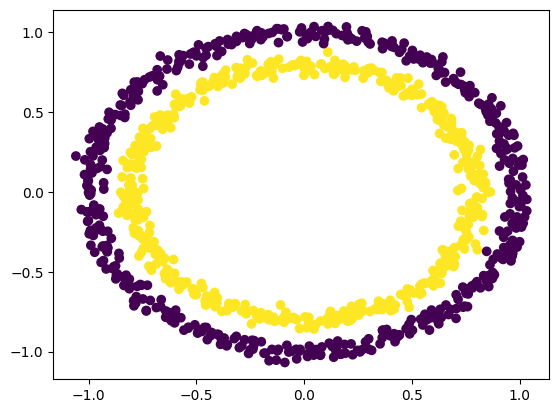

In [5]:
# Visualize

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y)

## 1.1 Check input and output shapes

In [6]:
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (1000, 2)
y.shape: (1000,)


In [7]:
# from array to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# creating train & test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

In [8]:
print(f'len(X_train): {len(X_train)}')
print(f'len(X_test): {len(X_test)}')
print(f'len(y_train): {len(y_train)}')
print(f'len(y_test): {len(y_test)}')

len(X_train): 800
len(X_test): 200
len(y_train): 800
len(y_test): 200


## 2. Building a model

let's build a model to classify out blue and red dots

To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training and test loop

In [9]:
# 1. Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
# 2. Construc a model

class CircleModel_V0(nn.Module):
  def __init__(self):
    super().__init__()
    # create 2 linear layers
    self.layer_1 = nn.Linear(in_features = 2,
                             out_features = 5)

    self.layer_2 = nn.Linear(in_features = 5,
                             out_features = 1)

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    output = self.layer_1(x)
    output = self.layer_2(x)
    return output

In [11]:
model_0 = CircleModel_V0().to(device)
print(model_0)

print(next(model_0.parameters()).device)

CircleModel_V0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)
cuda:0


In [12]:
# replicating the model above using nn.Sequential

# class CircleModel_V0(nn.Module):
#   def __init__(self):
#     super(CircleModel_V0, self).__init__()

#     self.two_linear_layers = nn.Sequential(
#       nn.Linear(in_features = 2, out_features = 5),
#       nn.Linear(in_features = 5, out_features = 1)
#     )

#     def forward(self, x):
#         return self.two_linear_layers(x)

# model_0 = CircleModel_V0()
# print(model_0)
# model_0.to(device)

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
print(model_0.state_dict())

OrderedDict([('0.weight', tensor([[ 0.3866,  0.0287],
        [ 0.2850, -0.3651],
        [-0.6040, -0.3679],
        [ 0.1226, -0.1108],
        [ 0.4366, -0.6783]], device='cuda:0')), ('0.bias', tensor([-0.4382, -0.2577,  0.1002,  0.0736,  0.4017], device='cuda:0')), ('1.weight', tensor([[-0.0984, -0.3797, -0.1972,  0.4058, -0.0987]], device='cuda:0')), ('1.bias', tensor([0.2732], device='cuda:0'))])


In [14]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.5495],
        [0.6054],
        [0.3265],
        [0.6131],
        [0.2050],
        [0.2400],
        [0.4937],
        [0.4078],
        [0.3320],
        [0.6078]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Loss functions are different for each task, classification and regression
which loss functions or optimizer should you use?



In [15]:
# Set up loss function

loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation function built-in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [16]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward (backpropagation)
5. Optimizer step (gradient descent)


### 3.1 Going from raw logits -> predictions probabilities -> prediction labels

In [17]:
# view the first 5 outputs of the foward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
print(y_logits)

tensor([[0.5495],
        [0.6054],
        [0.3265],
        [0.6131],
        [0.2050]], device='cuda:0')


In [18]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [19]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)
print(torch.round(y_pred_probs))

tensor([[0.6340],
        [0.6469],
        [0.5809],
        [0.6486],
        [0.5511]], device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


For our prediction probability values, we need to perform a range-style rounding on them:

 - `y_pred_probs` >= 0.5 `y=1` (class 1)
 - `y_pred_probs` < 0.5 `y=0` (class 0)

In [20]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

## 3.2 Building training loop

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  # Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # 2. Caculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                         y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer Step (gradient descent)
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    # Print what's going onononon
    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.71262 | Acc: 50.00% | Test Loss: 0.71861 Test acc: 50.00%
Epoch: 10 | Loss: 0.70213 | Acc: 50.00% | Test Loss: 0.70868 Test acc: 50.00%
Epoch: 20 | Loss: 0.69773 | Acc: 56.50% | Test Loss: 0.70426 Test acc: 51.50%
Epoch: 30 | Loss: 0.69578 | Acc: 53.37% | Test Loss: 0.70209 Test acc: 50.00%
Epoch: 40 | Loss: 0.69484 | Acc: 52.25% | Test Loss: 0.70086 Test acc: 48.00%
Epoch: 50 | Loss: 0.69433 | Acc: 52.12% | Test Loss: 0.70005 Test acc: 48.50%
Epoch: 60 | Loss: 0.69402 | Acc: 52.00% | Test Loss: 0.69944 Test acc: 47.00%
Epoch: 70 | Loss: 0.69382 | Acc: 51.38% | Test Loss: 0.69895 Test acc: 46.00%
Epoch: 80 | Loss: 0.69366 | Acc: 51.50% | Test Loss: 0.69854 Test acc: 47.00%
Epoch: 90 | Loss: 0.69355 | Acc: 51.12% | Test Loss: 0.69818 Test acc: 47.00%


## 4. Make predictions and evaluate the model

Visualize!

In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

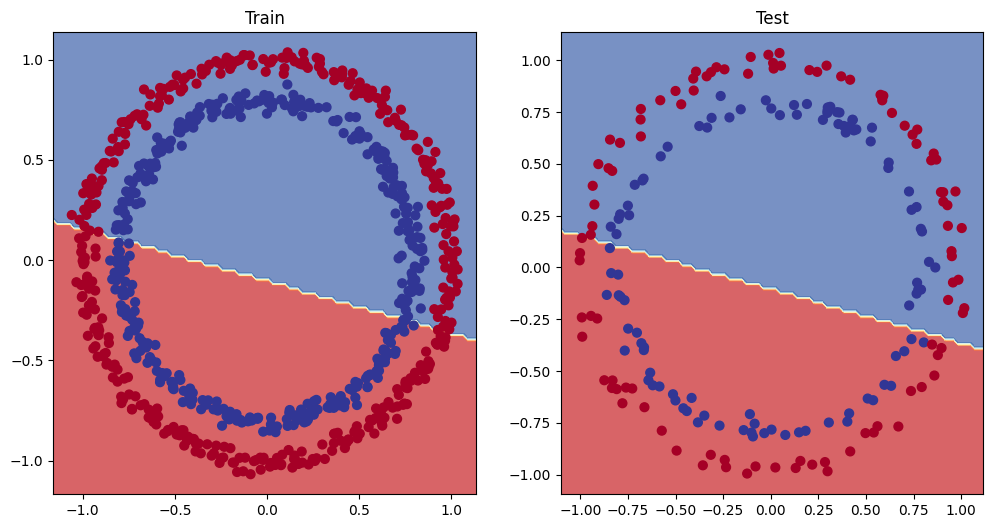

In [23]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers
* Add more hidden units
* Fit for longer
* Change activation functions
* Change the learning rate

(Notice that we're only changing the model and not the data!)

In [24]:
class CircleModel_V1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2,
                              out_features = 10)

    self.layer_2 = nn.Linear(in_features = 10,
                             out_features = 10)

    self.layer_3 = nn.Linear(in_features = 10,
                             out_features = 1)

  def forward(self, x):
      z = self.layer_1(x)
      z = self.layer_2(z)
      z = self.layer_3(z)
      return z

model_1 = CircleModel_V1().to(device)
model_1

CircleModel_V1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  # Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # 2. Caculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                         y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer Step (gradient descent)
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    # Print what's going onononon
    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.69261 Test acc: 51.00%
Epoch: 10 | Loss: 0.69369 | Acc: 50.25% | Test Loss: 0.69270 Test acc: 50.00%
Epoch: 20 | Loss: 0.69351 | Acc: 50.12% | Test Loss: 0.69283 Test acc: 49.50%
Epoch: 30 | Loss: 0.69339 | Acc: 50.50% | Test Loss: 0.69297 Test acc: 48.00%
Epoch: 40 | Loss: 0.69329 | Acc: 50.38% | Test Loss: 0.69310 Test acc: 49.00%
Epoch: 50 | Loss: 0.69322 | Acc: 49.88% | Test Loss: 0.69324 Test acc: 50.00%
Epoch: 60 | Loss: 0.69317 | Acc: 49.38% | Test Loss: 0.69336 Test acc: 51.50%
Epoch: 70 | Loss: 0.69312 | Acc: 49.38% | Test Loss: 0.69348 Test acc: 50.50%
Epoch: 80 | Loss: 0.69309 | Acc: 50.12% | Test Loss: 0.69359 Test acc: 50.00%
Epoch: 90 | Loss: 0.69307 | Acc: 50.50% | Test Loss: 0.69370 Test acc: 48.50%
Epoch: 100 | Loss: 0.69305 | Acc: 50.38% | Test Loss: 0.69379 Test acc: 48.00%
Epoch: 110 | Loss: 0.69303 | Acc: 50.88% | Test Loss: 0.69388 Test acc: 46.50%
Epoch: 120 | Loss: 0.69302 | Acc: 50.75% | Test Loss: 0.69396 T

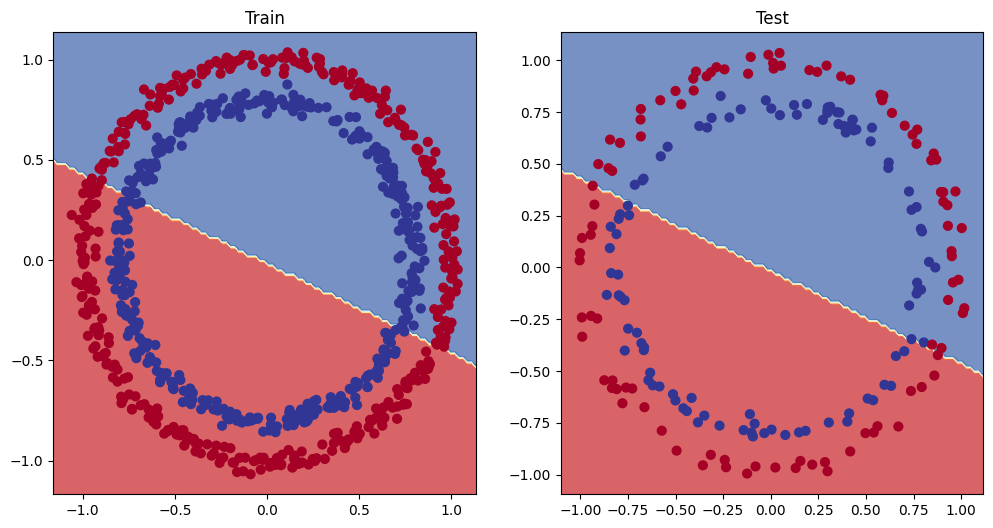

In [26]:
# Plot decision boundary of model_1

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [27]:
# testing the model on a different and smaller dataset

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim = 1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [28]:
# Create train und test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check lengths
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

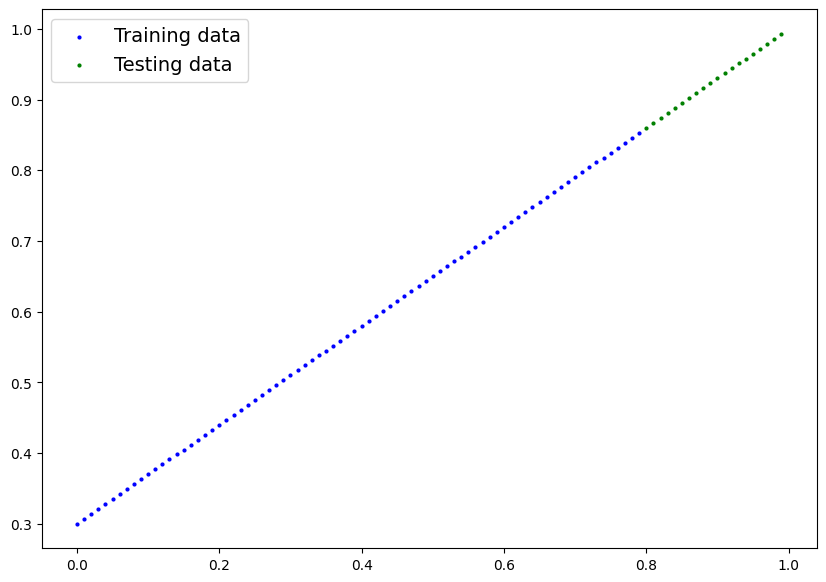

In [29]:
plot_predictions(train_data = X_train_regression,
                train_labels = y_train_regression,
                test_data = X_test_regression,
                test_labels = y_test_regression);

In [37]:
# Same architecture as model_1 (but using nn.Sequential())

model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Loss und optimizer

loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model_2.parameters(),
                            lr = 0.01)

# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1500

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training loop
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # print what is going on
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}')

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360
Epoch: 1000 | Loss: 0.01782 | Test Loss: 0.00333
Epoch: 1100 | Loss: 0.01674 | Test Loss: 0.00317
Epoch: 1200 | Loss: 0.01640 | Test Loss: 0.00316
Epoch: 1300 | Loss: 0.01648 | Test Loss: 0.00256
Epoch: 1400 | Loss: 0.01648 | Test Loss: 0.00323


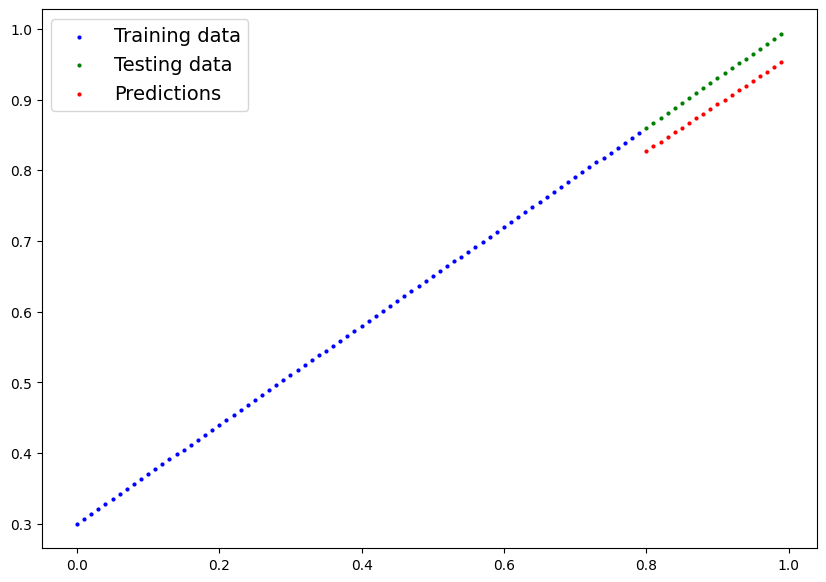

In [41]:
# eval mode

model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data = X_train_regression.cpu(),
                train_labels = y_train_regression.cpu(),
                test_data = X_test_regression.cpu(),
                test_labels = y_test_regression.cpu(),
                predictions = y_preds.cpu())

## 6. Introducing non-linearity

### 6.1 Recreating non-liear data (red and blue cirlces)

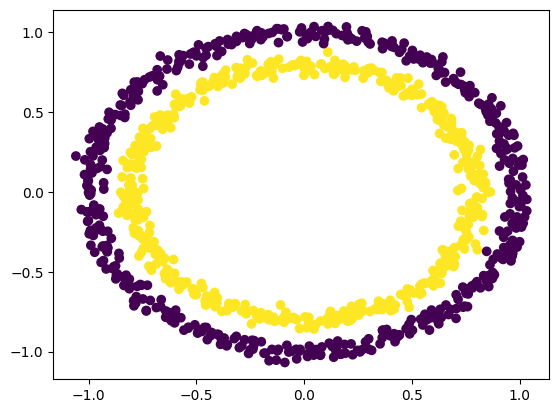

In [43]:
# Make and plot data

n_smaples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

plt.scatter(X[:, 0],
            X[:, 1],
            c = y)

In [46]:
# Convert data to tensor and the to train and test splits

X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

X_train[:5], y_train[:5]

<ipython-input-46-6d348d2c35a9>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)
<ipython-input-46-6d348d2c35a9>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).type(torch.float)


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a non-linear mode

In [70]:
# Build a model with non-linear function

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2,
                             out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10,
                             out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10,
                             out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.layer_3(x)
    return x

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [71]:
# Building a training loop, again...

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.2)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000
for epoch in range(epochs):

  model_3.train()

  # 1. forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. calculate the loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. zero the optimizer gradient
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  # 6. testing
  model_3.eval()
  with torch.inference_mode():
    # 6.1 test forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 6.2 test loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69312, Test acc: 50.00%
Epoch: 100 | Loss: 0.68978, Accuracy: 53.37% | Test loss: 0.68938, Test acc: 55.50%
Epoch: 200 | Loss: 0.68518, Accuracy: 52.75% | Test loss: 0.68409, Test acc: 56.50%
Epoch: 300 | Loss: 0.67520, Accuracy: 54.37% | Test loss: 0.67282, Test acc: 56.50%
Epoch: 400 | Loss: 0.65179, Accuracy: 63.88% | Test loss: 0.64756, Test acc: 67.50%
Epoch: 500 | Loss: 0.56917, Accuracy: 87.50% | Test loss: 0.57400, Test acc: 86.50%
Epoch: 600 | Loss: 0.37245, Accuracy: 97.88% | Test loss: 0.40668, Test acc: 92.50%
Epoch: 700 | Loss: 0.30881, Accuracy: 87.12% | Test loss: 0.34613, Test acc: 81.50%
Epoch: 800 | Loss: 0.09464, Accuracy: 99.88% | Test loss: 0.13391, Test acc: 99.50%
Epoch: 900 | Loss: 0.05634, Accuracy: 99.88% | Test loss: 0.08544, Test acc: 99.50%


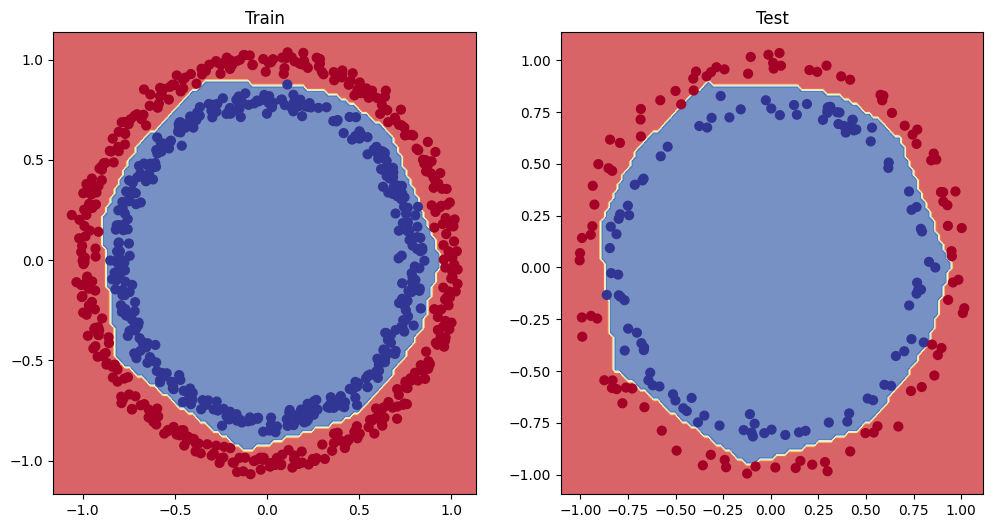

In [72]:
# Plot decision boundary of model_3

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [74]:
# creating a tensor

A = torch.arange(-10, 10, 1, dtype = torch.float32)
A.dtype

torch.float32

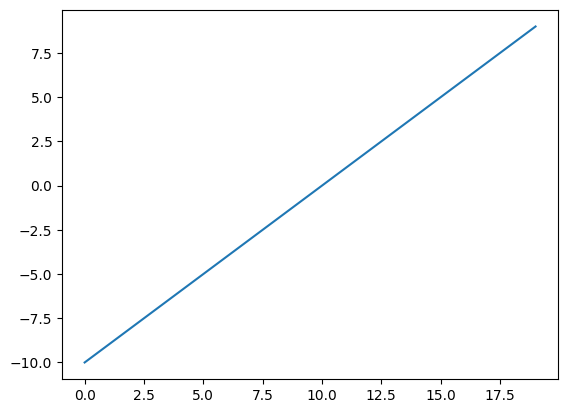

In [76]:
# Visualize the tensor
plt.plot(A)

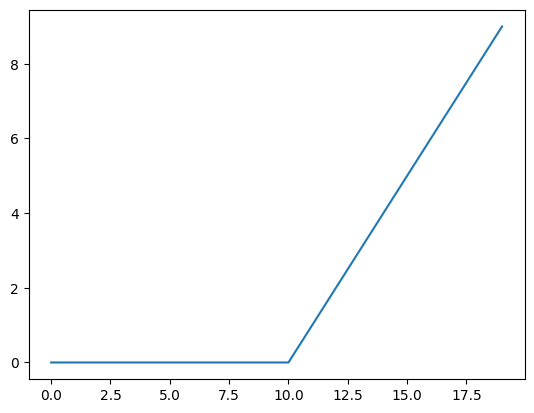

In [77]:
plt.plot(torch.relu(A))

In [78]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

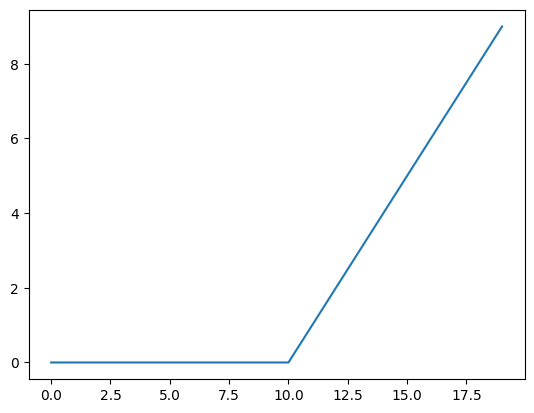

In [79]:
# plot our relu function

plt.plot(relu(A))

In [80]:
# out sigmoid

def sigmoid(x:torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

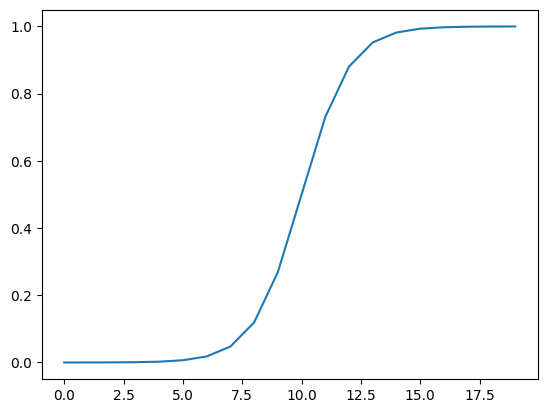

In [81]:
plt.plot(torch.sigmoid(A))

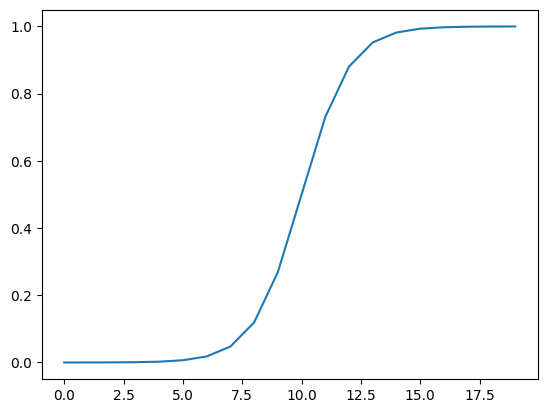

In [82]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem